In [94]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [95]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self): 
        return f"Value({self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other),  '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other) # a - b = a + (-b)
    
    def __pow__ (self, other):
        assert isinstance(other, (int, float)), "Only int or float powers are supported"
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other # swap the order of the operands because __mul__ is already defined for value * other
    
    def __truediv__(self, other):
        return self * other**-1 # a/b = a * (1/b)
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad # derivative of exp(x) is exp(x)
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward() 

In [96]:
from graphviz import Digraph

def trace(root):
    # builds a set of nodes and edges
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
        
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph creater a rectangular record node for it
        dot.node(uid, label= "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if the value has an operation, create a diamond node for it
            dot.node(name = uid + n._op, label=n._op)
            # and connect this node to itk
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect the nodes to their children
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot



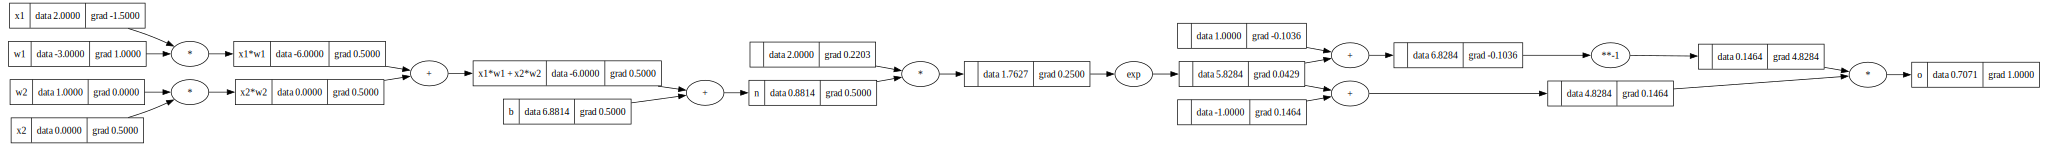

In [97]:
# inputs x1,x2
x1 = Value (2.0,label='x1')
x2 = Value (0.0,label='x2' )
# weights wl,w2
w1 = Value(-3.0,label='w1' )
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + bl
x1w1 = x1*w1; x1w1. label = 'x1*w1'
x2w2 = x2*w2; x2w2. label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e - 1) / (e + 1) 
o.label = 'o'
o.backward()
draw_dot(o)

In [98]:
class Neuron:
    def __init__(self, nin): # nin is the number of inputs
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1, 1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
        
class Layer:
    def __init__(self, nin, nout): # nout is the number of outputs in the layer
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs # if there is only one neuron, return the single output, otherwise return a list of outputs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()] # flatten the list of parameters from all neurons in the layer
    
class MLP:
    def __init__(self, nin, nouts): # nouts is a list of the number of outputs in each layer (sizes of all the layers we want in the MLP)
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [162]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1]) 
n(x)

Value(-0.42609960487668064)

In [163]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]
    # desired outputs

In [167]:

for k in range(20):
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))
    
    for p in n.parameters():
        p.grad = 0.0
        
    # backward pass
    loss.backward()
    
    # update weights
    for p in n.parameters():
        p.data += -0.05 * p.grad # gradient descent step
    
    print(k, loss.data)

0 0.009507943696806537
1 0.009256478121291429
2 0.00901796793696635
3 0.008791439625642557
4 0.008576014621517306
5 0.008370898027879041
6 0.008175368903628983
7 0.007988771870800817
8 0.007810509838306192
9 0.007640037672601642
10 0.0074768566746786485
11 0.007320509746126847
12 0.007170577146095874
13 0.007026672756638442
14 0.006888440786820163
15 0.006755552856660437
16 0.006627705410839611
17 0.006504617419505099
18 0.006386028329700024
19 0.006271696236136461


In [168]:
ypred

[Value(0.957732896761724),
 Value(-0.9699399853087837),
 Value(-0.979596664387722),
 Value(0.9437391109860679)]